# classical machine learning (sentence level)

## random forest

Fitting 3 folds for each of 16 candidates, totalling 48 fits


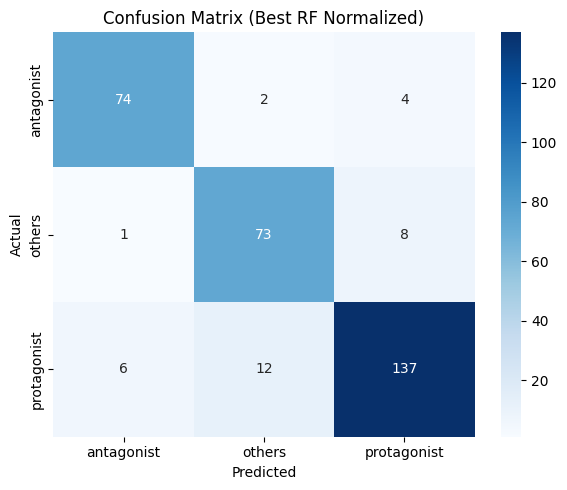


📊 Confusion Matrix:
             antagonist  others  protagonist
antagonist           74       2            4
others                1      73            8
protagonist           6      12          137

🏆 Best Random Forest (Normalized) Summary:
              precision    recall  f1-score     support
antagonist     0.913580  0.925000  0.919255   80.000000
others         0.839080  0.890244  0.863905   82.000000
protagonist    0.919463  0.883871  0.901316  155.000000
accuracy       0.895899  0.895899  0.895899    0.895899
macro avg      0.890708  0.899705  0.894825  317.000000
weighted avg   0.897185  0.895899  0.896166  317.000000

🔧 Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
📈 Precision: 0.8907
📈 Recall:    0.8997
📈 F1-score:  0.8948
🎯 Accuracy:  0.8959

📁 All results saved in: ./random_forest_normalized


In [2]:
import pandas as pd
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Load normalized data
df = pd.read_csv("sentence_level_normalized.csv")
df['text'] = df['text'].fillna("")
df['is_primary_in_sentence'] = df['is_primary_in_sentence'].fillna(0)

# Feature prep
X_num = df[['mention_count', 'word_count', 'is_primary_in_sentence']].astype(float)  # cast to float
tfidf = TfidfVectorizer(max_features=500)
X_text = tfidf.fit_transform(df['text'])

X = hstack([X_num, X_text])

# Label encoding
le = LabelEncoder()
y = le.fit_transform(df['type'])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Grid search params
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Run GridSearchCV
base_model = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(base_model, param_grid, cv=3, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

# Save root folder
root_dir = "./random_forest_normalized"
os.makedirs(root_dir, exist_ok=True)

# Save all grid search results
cv_results = pd.DataFrame(grid_search.cv_results_)
param_results = cv_results[
    ['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'mean_test_score']
]
param_results.to_csv(f"{root_dir}/all_hyperparams_results.csv", index=False)

# Save each variation
for _, row in param_results.iterrows():
    tag = f"rf-n{row['param_n_estimators']}-d{row['param_max_depth']}-s{row['param_min_samples_split']}-l{row['param_min_samples_leaf']}".replace("None", "NoneType")
    model_dir = os.path.join(root_dir, tag)
    os.makedirs(model_dir, exist_ok=True)

    model = RandomForestClassifier(
        n_estimators=row['param_n_estimators'],
        max_depth=None if row['param_max_depth'] == "NoneType" else row['param_max_depth'],
        min_samples_split=row['param_min_samples_split'],
        min_samples_leaf=row['param_min_samples_leaf'],
        class_weight='balanced',
        random_state=42
    )
    model.fit(X_train, y_train)

    y_pred_all = model.predict(X)
    df['predicted_type'] = le.inverse_transform(y_pred_all)
    df.to_csv(os.path.join(model_dir, "prediction.csv"), index=False)
    joblib.dump(model, os.path.join(model_dir, "model.pkl"))

# Evaluate best model
y_pred_best = best_rf.predict(X_test)
report_dict = classification_report(y_test, y_pred_best, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
acc = accuracy_score(y_test, y_pred_best)

# Save best model results
report_df.to_csv(f"{root_dir}/classification_report.csv", index=True)
with open(f"{root_dir}/best_params.txt", "w") as f:
    f.write(str(grid_search.best_params_))

joblib.dump(best_rf, f"{root_dir}/best_model.pkl")
joblib.dump(le, f"{root_dir}/label_encoder.pkl")
joblib.dump(tfidf, f"{root_dir}/tfidf.pkl")

df['predicted_type'] = le.inverse_transform(best_rf.predict(X))
df.to_csv(f"{root_dir}/best_prediction.csv", index=False)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Best RF Normalized)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig(f"{root_dir}/confusion_matrix.png")
plt.show()

# Print summary
print("\n📊 Confusion Matrix:")
print(cm_df)

print("\n🏆 Best Random Forest (Normalized) Summary:")
print(report_df)
print(f"\n🔧 Best Parameters: {grid_search.best_params_}")
print(f"📈 Precision: {report_dict['macro avg']['precision']:.4f}")
print(f"📈 Recall:    {report_dict['macro avg']['recall']:.4f}")
print(f"📈 F1-score:  {report_dict['macro avg']['f1-score']:.4f}")
print(f"🎯 Accuracy:  {acc:.4f}")
print(f"\n📁 All results saved in: {root_dir}")


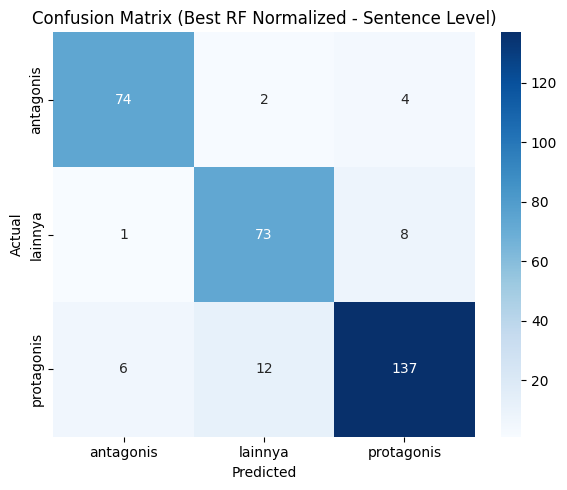

In [1]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns

# Load model, encoder, dan vectorizer
model = joblib.load("./random_forest_normalized/best_model.pkl")
le = joblib.load("./random_forest_normalized/label_encoder.pkl")
tfidf = joblib.load("./random_forest_normalized/tfidf.pkl")

# Load ulang data
df = pd.read_csv("sentence_level_normalized.csv")
df['text'] = df['text'].fillna("")
df['is_primary_in_sentence'] = df['is_primary_in_sentence'].fillna(0)

# Preprocessing fitur
X_num = df[['mention_count', 'word_count', 'is_primary_in_sentence']].astype(float)
X_text = tfidf.transform(df['text'])  # pakai transform
X = hstack([X_num, X_text])
y = le.transform(df['type'])

# Split ulang
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Prediksi
y_pred_best = model.predict(X_test)

# Label mapping
label_map = {
    'protagonist': 'protagonis',
    'antagonist': 'antagonis',
    'others': 'lainnya'
}
custom_labels = [label_map[label] for label in le.classes_]

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
cm_df = pd.DataFrame(cm, index=custom_labels, columns=custom_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Best RF Normalized - Sentence Level)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


🔄 Embedding sentences...


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rayssa\.cache\huggingface\hub\models--sentence-transformers--distiluse-base-multilingual-cased-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Batches: 100%|██████████| 50/50 [00:00<00:

Fitting 3 folds for each of 16 candidates, totalling 48 fits


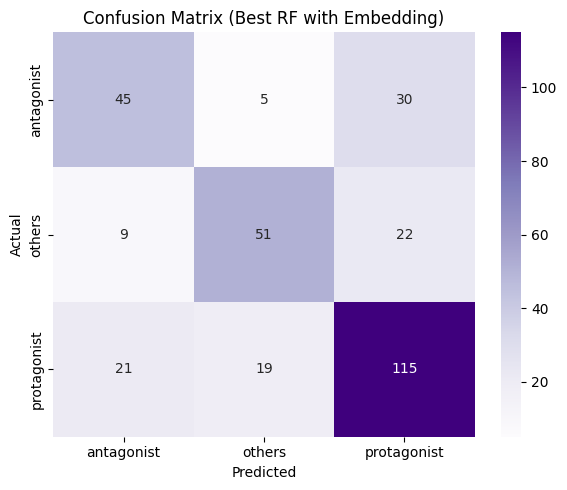


📊 Confusion Matrix:
             antagonist  others  protagonist
antagonist           45       5           30
others                9      51           22
protagonist          21      19          115

🏆 Best Random Forest (with Embedding) Summary:
              precision    recall  f1-score     support
antagonist     0.600000  0.562500  0.580645   80.000000
others         0.680000  0.621951  0.649682   82.000000
protagonist    0.688623  0.741935  0.714286  155.000000
accuracy       0.665615  0.665615  0.665615    0.665615
macro avg      0.656208  0.642129  0.648204  317.000000
weighted avg   0.664027  0.665615  0.663848  317.000000

🔧 Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
📈 Precision: 0.6562
📈 Recall:    0.6421
📈 F1-score:  0.6482
🎯 Accuracy:  0.6656

📁 All results saved in: ./random_forest_with_embedding


In [1]:
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from sentence_transformers import SentenceTransformer
from scipy.sparse import csr_matrix, hstack

# === 1. Load Data ===
df = pd.read_csv("sentence_level_normalized.csv")
df['text'] = df['text'].fillna("")
df['is_primary_in_sentence'] = df['is_primary_in_sentence'].fillna(0)

# === 2. Sentence Embedding ===
print("🔄 Embedding sentences...")
embedder = SentenceTransformer("distiluse-base-multilingual-cased-v2")
embeddings = embedder.encode(df['text'].tolist(), show_progress_bar=True)
embedding_df = pd.DataFrame(embeddings, columns=[f"emb_{i}" for i in range(embeddings.shape[1])])
embedding_df.index = df.index  # align with original dataframe

# === 3. Prepare Features ===
X_num = df[['mention_count', 'word_count', 'is_primary_in_sentence']].astype(float)
X = pd.concat([X_num, embedding_df], axis=1)

# === 4. Label Encoding ===
le = LabelEncoder()
y = le.fit_transform(df['type'])

# === 5. Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# === 6. Grid Search Hyperparameters ===
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

base_model = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(base_model, param_grid, cv=3, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

# === 7. Save Directory ===
root_dir = "./random_forest_with_embedding"
os.makedirs(root_dir, exist_ok=True)

# === 8. Save Grid Search Results ===
cv_results = pd.DataFrame(grid_search.cv_results_)
param_results = cv_results[[
    'param_n_estimators', 'param_max_depth', 'param_min_samples_split',
    'param_min_samples_leaf', 'mean_test_score'
]]
param_results.to_csv(f"{root_dir}/all_hyperparams_results.csv", index=False)

# === 9. Save Each Variation ===
for _, row in param_results.iterrows():
    tag = f"rf-n{row['param_n_estimators']}-d{row['param_max_depth']}-s{row['param_min_samples_split']}-l{row['param_min_samples_leaf']}".replace("None", "NoneType")
    model_dir = os.path.join(root_dir, tag)
    os.makedirs(model_dir, exist_ok=True)

    model = RandomForestClassifier(
        n_estimators=row['param_n_estimators'],
        max_depth=None if row['param_max_depth'] == "NoneType" else row['param_max_depth'],
        min_samples_split=row['param_min_samples_split'],
        min_samples_leaf=row['param_min_samples_leaf'],
        class_weight='balanced',
        random_state=42
    )
    model.fit(X_train, y_train)

    y_pred_all = model.predict(X)
    df['predicted_type'] = le.inverse_transform(y_pred_all)
    df.to_csv(os.path.join(model_dir, "prediction.csv"), index=False)
    joblib.dump(model, os.path.join(model_dir, "model.pkl"))

# === 10. Evaluate Best Model ===
y_pred_best = best_rf.predict(X_test)
report_dict = classification_report(y_test, y_pred_best, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
acc = accuracy_score(y_test, y_pred_best)

# Save best results
report_df.to_csv(f"{root_dir}/classification_report.csv", index=True)
with open(f"{root_dir}/best_params.txt", "w") as f:
    f.write(str(grid_search.best_params_))

joblib.dump(best_rf, f"{root_dir}/best_model.pkl")
joblib.dump(le, f"{root_dir}/label_encoder.pkl")
joblib.dump(embedder, f"{root_dir}/embedding_model.pkl")

df['predicted_type'] = le.inverse_transform(best_rf.predict(X))
df.to_csv(f"{root_dir}/best_prediction.csv", index=False)

# === 11. Confusion Matrix Plot ===
cm = confusion_matrix(y_test, y_pred_best)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix (Best RF with Embedding)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig(f"{root_dir}/confusion_matrix.png")
plt.show()

# === 12. Print Summary ===
print("\n📊 Confusion Matrix:")
print(cm_df)

print("\n🏆 Best Random Forest (with Embedding) Summary:")
print(report_df)
print(f"\n🔧 Best Parameters: {grid_search.best_params_}")
print(f"📈 Precision: {report_dict['macro avg']['precision']:.4f}")
print(f"📈 Recall:    {report_dict['macro avg']['recall']:.4f}")
print(f"📈 F1-score:  {report_dict['macro avg']['f1-score']:.4f}")
print(f"🎯 Accuracy:  {acc:.4f}")
print(f"\n📁 All results saved in: {root_dir}")


## SVM

Fitting 3 folds for each of 3 candidates, totalling 9 fits


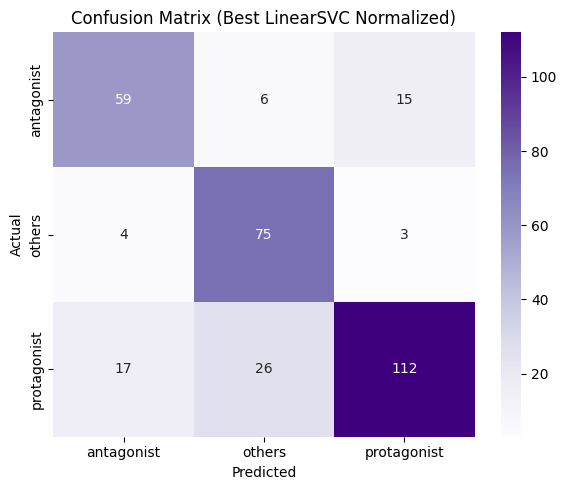


📊 Confusion Matrix:
             antagonist  others  protagonist
antagonist           59       6           15
others                4      75            3
protagonist          17      26          112

🏆 Best LinearSVC (Normalized) Summary:
              precision    recall  f1-score     support
antagonist     0.737500  0.737500  0.737500   80.000000
others         0.700935  0.914634  0.793651   82.000000
protagonist    0.861538  0.722581  0.785965  155.000000
accuracy       0.776025  0.776025  0.776025    0.776025
macro avg      0.766658  0.791572  0.772372  317.000000
weighted avg   0.788691  0.776025  0.775722  317.000000

🔧 Best Parameters: {'C': 0.1}
📈 Precision: 0.7667
📈 Recall:    0.7916
📈 F1-score:  0.7724
🎯 Accuracy:  0.7760

📁 All results saved in: ./linear_svc_normalized


In [3]:
import pandas as pd
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack

# Load normalized dataset
df = pd.read_csv("sentence_level_normalized.csv")
df['text'] = df['text'].fillna("")
df['is_primary_in_sentence'] = df['is_primary_in_sentence'].fillna(0)

# Normalize numeric features
numeric_cols = ['mention_count', 'word_count']
binary_cols = ['is_primary_in_sentence']
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Prepare final numeric feature set
X_num = df[numeric_cols + binary_cols].astype(float)
tfidf = TfidfVectorizer(max_features=500)
X_text = tfidf.fit_transform(df['text'])

X = hstack([X_num, X_text])
le = LabelEncoder()
y = le.fit_transform(df['type'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Define grid search parameters
param_grid = {
    'C': [0.1, 1.0, 10.0]
}

# Grid search
base_model = LinearSVC(class_weight='balanced', max_iter=10000)
grid_search = GridSearchCV(base_model, param_grid, cv=3, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Create root folder
root_dir = "./linear_svc_normalized"
os.makedirs(root_dir, exist_ok=True)

# Save grid search results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results[['param_C', 'mean_test_score']].to_csv(f"{root_dir}/all_params_results.csv", index=False)

# Save each variation
for _, row in cv_results.iterrows():
    C_val = row['param_C']
    tag = f"svc-C{str(C_val).replace('.', '')}"
    model_dir = os.path.join(root_dir, tag)
    os.makedirs(model_dir, exist_ok=True)

    model = LinearSVC(C=C_val, class_weight='balanced', max_iter=10000)
    model.fit(X_train, y_train)
    y_pred_all = model.predict(X)
    df['predicted_type'] = le.inverse_transform(y_pred_all)
    df.to_csv(os.path.join(model_dir, "prediction.csv"), index=False)
    joblib.dump(model, os.path.join(model_dir, "model.pkl"))

# Evaluate best model
y_pred = best_model.predict(X_test)
report_dict = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
acc = accuracy_score(y_test, y_pred)

# Save everything
report_df.to_csv(f"{root_dir}/classification_report.csv", index=True)
with open(f"{root_dir}/best_params.txt", "w") as f:
    f.write(str(grid_search.best_params_))
joblib.dump(best_model, os.path.join(root_dir, "best_model.pkl"))
joblib.dump(tfidf, os.path.join(root_dir, "tfidf.pkl"))
joblib.dump(le, os.path.join(root_dir, "label_encoder.pkl"))

df['predicted_type'] = le.inverse_transform(best_model.predict(X))
df.to_csv(os.path.join(root_dir, "best_prediction.csv"), index=False)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix (Best LinearSVC Normalized)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig(f"{root_dir}/confusion_matrix.png")
plt.show()

# Print summary
print("\n📊 Confusion Matrix:")
print(cm_df)

print("\n🏆 Best LinearSVC (Normalized) Summary:")
print(report_df)

print(f"\n🔧 Best Parameters: {grid_search.best_params_}")
print(f"📈 Precision: {report_dict['macro avg']['precision']:.4f}")
print(f"📈 Recall:    {report_dict['macro avg']['recall']:.4f}")
print(f"📈 F1-score:  {report_dict['macro avg']['f1-score']:.4f}")
print(f"🎯 Accuracy:  {acc:.4f}")
print(f"\n📁 All results saved in: {root_dir}")


## svm with rbf kernel

Fitting 3 folds for each of 9 candidates, totalling 27 fits


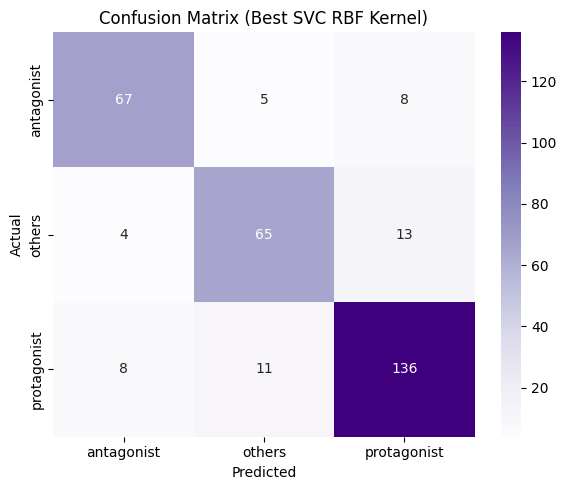


📊 Confusion Matrix:
             antagonist  others  protagonist
antagonist           67       5            8
others                4      65           13
protagonist           8      11          136

🏆 Best SVC RBF Summary:
              precision    recall  f1-score     support
antagonist     0.848101  0.837500  0.842767   80.000000
others         0.802469  0.792683  0.797546   82.000000
protagonist    0.866242  0.877419  0.871795  155.000000
accuracy       0.845426  0.845426  0.845426    0.845426
macro avg      0.838937  0.835867  0.837369  317.000000
weighted avg   0.845167  0.845426  0.845263  317.000000

🔧 Best Parameters: {'C': 10, 'gamma': 'scale'}
📈 Precision: 0.8389
📈 Recall:    0.8359
📈 F1-score:  0.8374
🎯 Accuracy:  0.8454

📁 All results saved in: ./svc_rbf_only


In [1]:
import pandas as pd
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Load dataset
df = pd.read_csv("sentence_level_normalized.csv")
df['text'] = df['text'].fillna("")
df['is_primary_in_sentence'] = df['is_primary_in_sentence'].fillna(0)

# Normalisasi fitur numerik
numeric_cols = ['mention_count', 'word_count']
binary_cols = ['is_primary_in_sentence']
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Gabungkan semua fitur
X_num = df[numeric_cols + binary_cols].astype(float)
tfidf = TfidfVectorizer(max_features=500)
X_text = tfidf.fit_transform(df['text'])
X = hstack([X_num, X_text])

# Encode label
le = LabelEncoder()
y = le.fit_transform(df['type'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Grid search khusus untuk kernel RBF
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1]
}

svc = SVC(kernel='rbf', class_weight='balanced')
grid_search = GridSearchCV(svc, param_grid, cv=3, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Simpan hasil
root_dir = "./svc_rbf_only"
os.makedirs(root_dir, exist_ok=True)

cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results[['param_C', 'param_gamma', 'mean_test_score']].to_csv(f"{root_dir}/all_params_results.csv", index=False)

# Simpan model dan prediksi terbaik
y_pred = best_model.predict(X_test)
report_dict = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
acc = accuracy_score(y_test, y_pred)

# Simpan hasil evaluasi
report_df.to_csv(f"{root_dir}/classification_report.csv", index=True)
with open(f"{root_dir}/best_params.txt", "w") as f:
    f.write(str(grid_search.best_params_))
joblib.dump(best_model, os.path.join(root_dir, "best_model.pkl"))
joblib.dump(tfidf, os.path.join(root_dir, "tfidf.pkl"))
joblib.dump(le, os.path.join(root_dir, "label_encoder.pkl"))

df['predicted_type'] = le.inverse_transform(best_model.predict(X))
df.to_csv(os.path.join(root_dir, "best_prediction.csv"), index=False)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix (Best SVC RBF Kernel)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig(f"{root_dir}/confusion_matrix.png")
plt.show()

# Print summary
print("\n📊 Confusion Matrix:")
print(cm_df)

print("\n🏆 Best SVC RBF Summary:")
print(report_df)

print(f"\n🔧 Best Parameters: {grid_search.best_params_}")
print(f"📈 Precision: {report_dict['macro avg']['precision']:.4f}")
print(f"📈 Recall:    {report_dict['macro avg']['recall']:.4f}")
print(f"📈 F1-score:  {report_dict['macro avg']['f1-score']:.4f}")
print(f"🎯 Accuracy:  {acc:.4f}")
print(f"\n📁 All results saved in: {root_dir}")


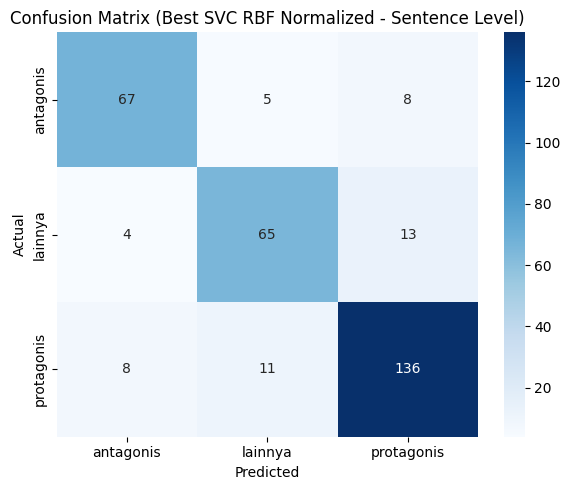

In [2]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns

# Load komponen yang sudah disimpan
model = joblib.load("./svc_rbf_only/best_model.pkl")
le = joblib.load("./svc_rbf_only/label_encoder.pkl")
tfidf = joblib.load("./svc_rbf_only/tfidf.pkl")

# Load dan siapkan data
df = pd.read_csv("sentence_level_normalized.csv")
df['text'] = df['text'].fillna("")
df['is_primary_in_sentence'] = df['is_primary_in_sentence'].fillna(0)

# Normalisasi ulang fitur numerik
numeric_cols = ['mention_count', 'word_count']
binary_cols = ['is_primary_in_sentence']
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Gabungkan fitur
X_num = df[numeric_cols + binary_cols].astype(float)
X_text = tfidf.transform(df['text'])
X = hstack([X_num, X_text])
y = le.transform(df['type'])

# Split ulang
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Prediksi ulang
y_pred = model.predict(X_test)

# Mapping label ke Bahasa Indonesia
label_map = {
    'protagonist': 'protagonis',
    'antagonist': 'antagonis',
    'others': 'lainnya'
}
custom_labels = [label_map[label] for label in le.classes_]

# Buat confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=custom_labels, columns=custom_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Best SVC RBF Normalized - Sentence Level)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


## svm poly

Fitting 3 folds for each of 18 candidates, totalling 54 fits


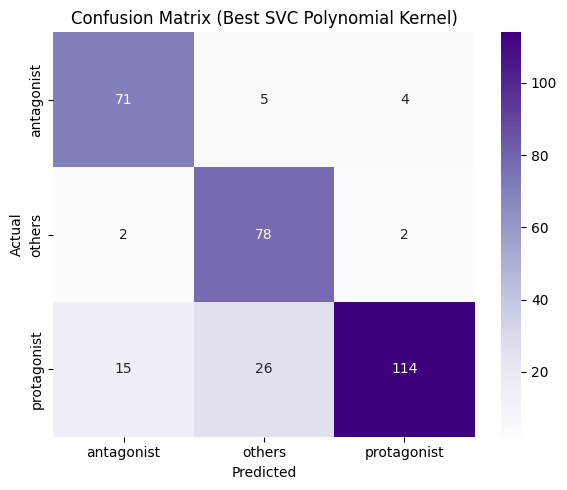


📊 Confusion Matrix:
             antagonist  others  protagonist
antagonist           71       5            4
others                2      78            2
protagonist          15      26          114

🏆 Best SVC Poly Summary:
              precision    recall  f1-score     support
antagonist     0.806818  0.887500  0.845238   80.000000
others         0.715596  0.951220  0.816754   82.000000
protagonist    0.950000  0.735484  0.829091  155.000000
accuracy       0.829653  0.829653  0.829653    0.829653
macro avg      0.824138  0.858068  0.830361  317.000000
weighted avg   0.853231  0.829653  0.829975  317.000000

🔧 Best Parameters: {'C': 1, 'coef0': 1.0, 'degree': 2}
📈 Precision: 0.8241
📈 Recall:    0.8581
📈 F1-score:  0.8304
🎯 Accuracy:  0.8297

📁 All results saved in: ./svc_poly_only


In [2]:
import pandas as pd
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Load dataset
df = pd.read_csv("sentence_level_normalized.csv")
df['text'] = df['text'].fillna("")
df['is_primary_in_sentence'] = df['is_primary_in_sentence'].fillna(0)

# Normalisasi fitur numerik
numeric_cols = ['mention_count', 'word_count']
binary_cols = ['is_primary_in_sentence']
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Gabungkan semua fitur
X_num = df[numeric_cols + binary_cols].astype(float)
tfidf = TfidfVectorizer(max_features=500)
X_text = tfidf.fit_transform(df['text'])
X = hstack([X_num, X_text])

# Encode label
le = LabelEncoder()
y = le.fit_transform(df['type'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Grid search untuk kernel polynomial
param_grid = {
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4],        # derajat polinomial
    'coef0': [0.0, 1.0]         # konstanta bebas dalam kernel polynomial
}

svc = SVC(kernel='poly', class_weight='balanced')
grid_search = GridSearchCV(svc, param_grid, cv=3, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Simpan hasil
root_dir = "./svc_poly_only"
os.makedirs(root_dir, exist_ok=True)

cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results[['param_C', 'param_degree', 'param_coef0', 'mean_test_score']].to_csv(f"{root_dir}/all_params_results.csv", index=False)

# Simpan model dan prediksi terbaik
y_pred = best_model.predict(X_test)
report_dict = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
acc = accuracy_score(y_test, y_pred)

# Simpan evaluasi
report_df.to_csv(f"{root_dir}/classification_report.csv", index=True)
with open(f"{root_dir}/best_params.txt", "w") as f:
    f.write(str(grid_search.best_params_))
joblib.dump(best_model, os.path.join(root_dir, "best_model.pkl"))
joblib.dump(tfidf, os.path.join(root_dir, "tfidf.pkl"))
joblib.dump(le, os.path.join(root_dir, "label_encoder.pkl"))

df['predicted_type'] = le.inverse_transform(best_model.predict(X))
df.to_csv(os.path.join(root_dir, "best_prediction.csv"), index=False)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix (Best SVC Polynomial Kernel)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig(f"{root_dir}/confusion_matrix.png")
plt.show()

# Print summary
print("\n📊 Confusion Matrix:")
print(cm_df)

print("\n🏆 Best SVC Poly Summary:")
print(report_df)

print(f"\n🔧 Best Parameters: {grid_search.best_params_}")
print(f"📈 Precision: {report_dict['macro avg']['precision']:.4f}")
print(f"📈 Recall:    {report_dict['macro avg']['recall']:.4f}")
print(f"📈 F1-score:  {report_dict['macro avg']['f1-score']:.4f}")
print(f"🎯 Accuracy:  {acc:.4f}")
print(f"\n📁 All results saved in: {root_dir}")


## logistic regression

Fitting 3 folds for each of 3 candidates, totalling 9 fits


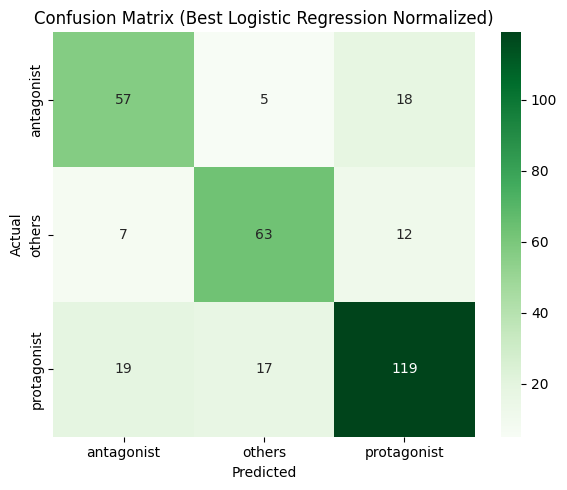


📊 Confusion Matrix:
             antagonist  others  protagonist
antagonist           57       5           18
others                7      63           12
protagonist          19      17          119

🏆 Best Logistic Regression (Normalized) Summary:
              precision    recall  f1-score     support
antagonist     0.686747  0.712500  0.699387   80.000000
others         0.741176  0.768293  0.754491   82.000000
protagonist    0.798658  0.767742  0.782895  155.000000
accuracy       0.753943  0.753943  0.753943    0.753943
macro avg      0.742194  0.749512  0.745591  317.000000
weighted avg   0.755546  0.753943  0.754473  317.000000

🔧 Best Parameters: {'C': 10.0}
📈 Precision: 0.7422
📈 Recall:    0.7495
📈 F1-score:  0.7456
🎯 Accuracy:  0.7539

📁 All results saved in: ./logistic_regression_normalized


In [4]:
import pandas as pd
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Load normalized dataset
df = pd.read_csv("sentence_level_normalized.csv")
df['text'] = df['text'].fillna("")
df['is_primary_in_sentence'] = df['is_primary_in_sentence'].fillna(0)

# Normalize numeric features
numeric_cols = ['mention_count', 'word_count']
binary_cols = ['is_primary_in_sentence']
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Feature prep
X_num = df[numeric_cols + binary_cols].astype(float)
tfidf = TfidfVectorizer(max_features=500)
X_text = tfidf.fit_transform(df['text'])

X = hstack([X_num, X_text])
le = LabelEncoder()
y = le.fit_transform(df['type'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Grid search
param_grid = {'C': [0.1, 1.0, 10.0]}
base_model = LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')
grid_search = GridSearchCV(base_model, param_grid, cv=3, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Save root dir
root_dir = "./logistic_regression_normalized"
os.makedirs(root_dir, exist_ok=True)

# Save grid search results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results[['param_C', 'mean_test_score']].to_csv(f"{root_dir}/all_params_results.csv", index=False)

# Save each variation
for _, row in cv_results.iterrows():
    C_val = row['param_C']
    tag = f"lr-C{str(C_val).replace('.', '')}"
    model_dir = os.path.join(root_dir, tag)
    os.makedirs(model_dir, exist_ok=True)

    model = LogisticRegression(C=C_val, class_weight='balanced', max_iter=1000, solver='liblinear')
    model.fit(X_train, y_train)
    y_pred_all = model.predict(X)
    df['predicted_type'] = le.inverse_transform(y_pred_all)
    df.to_csv(os.path.join(model_dir, "prediction.csv"), index=False)
    joblib.dump(model, os.path.join(model_dir, "model.pkl"))

# Evaluate best model
y_pred = best_model.predict(X_test)
report_dict = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
acc = accuracy_score(y_test, y_pred)

# Save final model outputs
report_df.to_csv(f"{root_dir}/classification_report.csv", index=True)
with open(f"{root_dir}/best_params.txt", "w") as f:
    f.write(str(grid_search.best_params_))
joblib.dump(best_model, os.path.join(root_dir, "best_model.pkl"))
joblib.dump(tfidf, os.path.join(root_dir, "tfidf.pkl"))
joblib.dump(le, os.path.join(root_dir, "label_encoder.pkl"))

df['predicted_type'] = le.inverse_transform(best_model.predict(X))
df.to_csv(os.path.join(root_dir, "best_prediction.csv"), index=False)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix (Best Logistic Regression Normalized)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig(f"{root_dir}/confusion_matrix.png")
plt.show()

# Final summary
print("\n📊 Confusion Matrix:")
print(cm_df)

print("\n🏆 Best Logistic Regression (Normalized) Summary:")
print(report_df)

print(f"\n🔧 Best Parameters: {grid_search.best_params_}")
print(f"📈 Precision: {report_dict['macro avg']['precision']:.4f}")
print(f"📈 Recall:    {report_dict['macro avg']['recall']:.4f}")
print(f"📈 F1-score:  {report_dict['macro avg']['f1-score']:.4f}")
print(f"🎯 Accuracy:  {acc:.4f}")
print(f"\n📁 All results saved in: {root_dir}")


## naive bayes

Fitting 3 folds for each of 3 candidates, totalling 9 fits


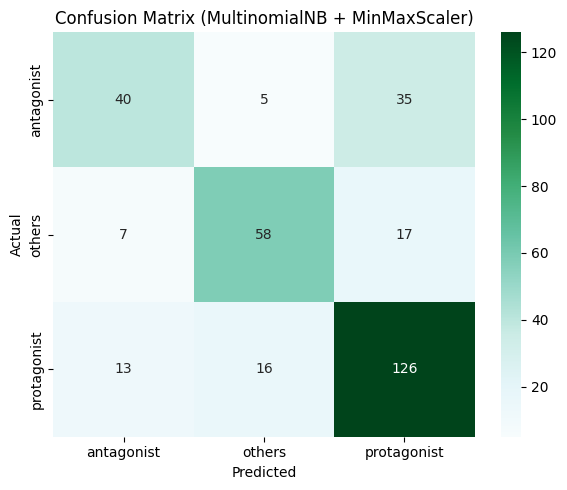


📊 Confusion Matrix:
             antagonist  others  protagonist
antagonist           40       5           35
others                7      58           17
protagonist          13      16          126

🏆 Best MultinomialNB (MinMax) Summary:
              precision    recall  f1-score     support
antagonist     0.666667  0.500000  0.571429   80.000000
others         0.734177  0.707317  0.720497   82.000000
protagonist    0.707865  0.812903  0.756757  155.000000
accuracy       0.706625  0.706625  0.706625    0.706625
macro avg      0.702903  0.673407  0.682894  317.000000
weighted avg   0.704274  0.706625  0.700607  317.000000

🔧 Best Parameters: {'alpha': 0.5}
📈 Precision: 0.7029
📈 Recall:    0.6734
📈 F1-score:  0.6829
🎯 Accuracy:  0.7066

📁 All results saved in: ./naive_bayes_minmax


In [1]:
import pandas as pd
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Load original dataset
df = pd.read_csv("sentence_level.csv")
df['text'] = df['text'].fillna("")
df['is_primary_in_sentence'] = df['is_primary_in_sentence'].fillna(0)

# Define columns
numeric_cols = ['mention_count', 'word_count']
binary_cols = ['is_primary_in_sentence']

# Apply MinMaxScaler (so Naive Bayes can handle it)
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Final numeric feature set
X_num = df[numeric_cols + binary_cols].astype(float)
tfidf = TfidfVectorizer(max_features=500)
X_text = tfidf.fit_transform(df['text'])

X = hstack([X_num, X_text])
le = LabelEncoder()
y = le.fit_transform(df['type'])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Grid Search for alpha
param_grid = {'alpha': [0.1, 0.5, 1.0]}
base_model = MultinomialNB()
grid_search = GridSearchCV(base_model, param_grid, cv=3, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Save directory
root_dir = "./naive_bayes_minmax"
os.makedirs(root_dir, exist_ok=True)

# Save all param results
cv_results = pd.DataFrame(grid_search.cv_results_)
param_results = cv_results[['param_alpha', 'mean_test_score']]
param_results.to_csv(f"{root_dir}/all_params_results.csv", index=False)

# Save each variant
for _, row in param_results.iterrows():
    alpha_val = row['param_alpha']
    tag = f"nb-alpha{str(alpha_val).replace('.', '')}"
    model_dir = os.path.join(root_dir, tag)
    os.makedirs(model_dir, exist_ok=True)

    model = MultinomialNB(alpha=alpha_val)
    model.fit(X_train, y_train)
    y_all_pred = model.predict(X)
    df['predicted_type'] = le.inverse_transform(y_all_pred)
    df.to_csv(os.path.join(model_dir, "prediction.csv"), index=False)
    joblib.dump(model, os.path.join(model_dir, "model.pkl"))

# Evaluate best model
y_pred = best_model.predict(X_test)
report_dict = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
acc = accuracy_score(y_test, y_pred)

# Save best results
report_df.to_csv(f"{root_dir}/classification_report.csv", index=True)
with open(f"{root_dir}/best_params.txt", "w") as f:
    f.write(str(grid_search.best_params_))

joblib.dump(best_model, os.path.join(root_dir, "best_model.pkl"))
joblib.dump(tfidf, os.path.join(root_dir, "tfidf.pkl"))
joblib.dump(le, os.path.join(root_dir, "label_encoder.pkl"))

df['predicted_type'] = le.inverse_transform(best_model.predict(X))
df.to_csv(os.path.join(root_dir, "best_prediction.csv"), index=False)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='BuGn')
plt.title('Confusion Matrix (MultinomialNB + MinMaxScaler)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig(f"{root_dir}/confusion_matrix.png")
plt.show()

# Print final summary
print("\n📊 Confusion Matrix:")
print(cm_df)

print("\n🏆 Best MultinomialNB (MinMax) Summary:")
print(report_df)

print(f"\n🔧 Best Parameters: {grid_search.best_params_}")
print(f"📈 Precision: {report_dict['macro avg']['precision']:.4f}")
print(f"📈 Recall:    {report_dict['macro avg']['recall']:.4f}")
print(f"📈 F1-score:  {report_dict['macro avg']['f1-score']:.4f}")
print(f"🎯 Accuracy:  {acc:.4f}")
print(f"\n📁 All results saved in: {root_dir}")


Fitting 3 folds for each of 3 candidates, totalling 9 fits


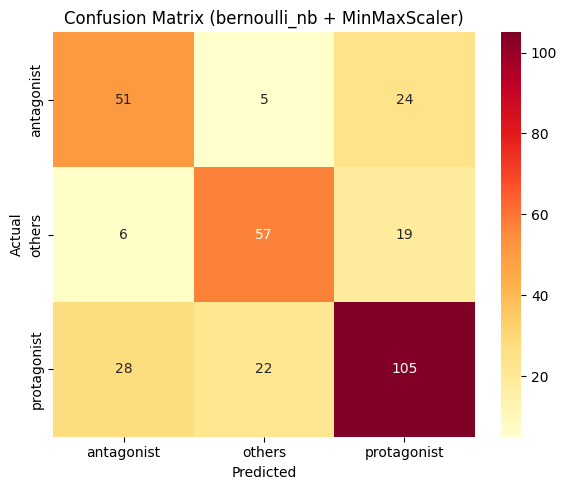


📊 Confusion Matrix (bernoulli_nb):
             antagonist  others  protagonist
antagonist           51       5           24
others                6      57           19
protagonist          28      22          105

🏆 bernoulli_nb + MinMax Summary:
              precision    recall  f1-score     support
antagonist     0.600000  0.637500  0.618182   80.000000
others         0.678571  0.695122  0.686747   82.000000
protagonist    0.709459  0.677419  0.693069  155.000000
accuracy       0.671924  0.671924  0.671924    0.671924
macro avg      0.662677  0.670014  0.665999  317.000000
weighted avg   0.673846  0.671924  0.672535  317.000000

🔧 Best Parameters: {'alpha': 0.5}
📈 Precision: 0.6627
📈 Recall:    0.6700
📈 F1-score:  0.6660
🎯 Accuracy:  0.6719

📁 All results saved in: ./bernoulli_nb_minmax
Fitting 3 folds for each of 3 candidates, totalling 9 fits


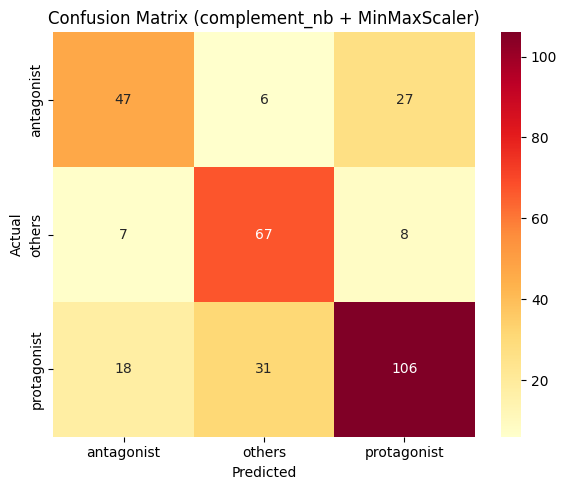


📊 Confusion Matrix (complement_nb):
             antagonist  others  protagonist
antagonist           47       6           27
others                7      67            8
protagonist          18      31          106

🏆 complement_nb + MinMax Summary:
              precision    recall  f1-score     support
antagonist     0.652778  0.587500  0.618421   80.000000
others         0.644231  0.817073  0.720430   82.000000
protagonist    0.751773  0.683871  0.716216  155.000000
accuracy       0.694006  0.694006  0.694006    0.694006
macro avg      0.682927  0.696148  0.685022  317.000000
weighted avg   0.698972  0.694006  0.692626  317.000000

🔧 Best Parameters: {'alpha': 1.0}
📈 Precision: 0.6829
📈 Recall:    0.6961
📈 F1-score:  0.6850
🎯 Accuracy:  0.6940

📁 All results saved in: ./complement_nb_minmax


In [2]:
import pandas as pd
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB, ComplementNB
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Load base dataset
df = pd.read_csv("sentence_level.csv")
df['text'] = df['text'].fillna("")
df['is_primary_in_sentence'] = df['is_primary_in_sentence'].fillna(0)

# MinMaxScaler on numeric features
numeric_cols = ['mention_count', 'word_count']
binary_cols = ['is_primary_in_sentence']
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

X_num = df[numeric_cols + binary_cols].astype(float)
y = LabelEncoder().fit_transform(df['type'])

def run_nb_variant(model_class, name, vectorizer_args, param_grid):
    root_dir = f"./{name.lower()}_minmax"
    os.makedirs(root_dir, exist_ok=True)

    tfidf = TfidfVectorizer(**vectorizer_args)
    X_text = tfidf.fit_transform(df['text'])
    X = hstack([X_num, X_text])

    le = LabelEncoder()
    y = le.fit_transform(df['type'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    grid_search = GridSearchCV(model_class(), param_grid, cv=3, scoring='f1_macro', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Save all param results
    cv_results = pd.DataFrame(grid_search.cv_results_)
    param_results = cv_results[[col for col in cv_results.columns if col.startswith("param_")] + ['mean_test_score']]
    param_results.to_csv(f"{root_dir}/all_params_results.csv", index=False)

    # Save each variation
    for _, row in param_results.iterrows():
        alpha_val = row['param_alpha']
        tag = f"nb-alpha{str(alpha_val).replace('.', '')}"
        model_dir = os.path.join(root_dir, tag)
        os.makedirs(model_dir, exist_ok=True)

        model = model_class(alpha=alpha_val)
        model.fit(X_train, y_train)
        y_all_pred = model.predict(X)
        df['predicted_type'] = le.inverse_transform(y_all_pred)
        df.to_csv(os.path.join(model_dir, "prediction.csv"), index=False)
        joblib.dump(model, os.path.join(model_dir, "model.pkl"))

    # Evaluate best model
    y_pred = best_model.predict(X_test)
    report_dict = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    acc = accuracy_score(y_test, y_pred)

    # Save best model
    report_df.to_csv(f"{root_dir}/classification_report.csv", index=True)
    with open(f"{root_dir}/best_params.txt", "w") as f:
        f.write(str(grid_search.best_params_))
    joblib.dump(best_model, os.path.join(root_dir, "best_model.pkl"))
    joblib.dump(tfidf, os.path.join(root_dir, "tfidf.pkl"))
    joblib.dump(le, os.path.join(root_dir, "label_encoder.pkl"))

    df['predicted_type'] = le.inverse_transform(best_model.predict(X))
    df.to_csv(os.path.join(root_dir, "best_prediction.csv"), index=False)

    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlOrRd')
    plt.title(f'Confusion Matrix ({name} + MinMaxScaler)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(f"{root_dir}/confusion_matrix.png")
    plt.show()

    print(f"\n📊 Confusion Matrix ({name}):")
    print(cm_df)
    print(f"\n🏆 {name} + MinMax Summary:")
    print(report_df)
    print(f"\n🔧 Best Parameters: {grid_search.best_params_}")
    print(f"📈 Precision: {report_dict['macro avg']['precision']:.4f}")
    print(f"📈 Recall:    {report_dict['macro avg']['recall']:.4f}")
    print(f"📈 F1-score:  {report_dict['macro avg']['f1-score']:.4f}")
    print(f"🎯 Accuracy:  {acc:.4f}")
    print(f"\n📁 All results saved in: {root_dir}")

# Run for BernoulliNB (binary TF-IDF)
run_nb_variant(
    model_class=BernoulliNB,
    name="bernoulli_nb",
    vectorizer_args={'max_features': 500, 'binary': True},
    param_grid={'alpha': [0.1, 0.5, 1.0]}
)

# Run for ComplementNB
run_nb_variant(
    model_class=ComplementNB,
    name="complement_nb",
    vectorizer_args={'max_features': 500},
    param_grid={'alpha': [0.1, 0.5, 1.0]}
)


Fitting 3 folds for each of 3 candidates, totalling 9 fits


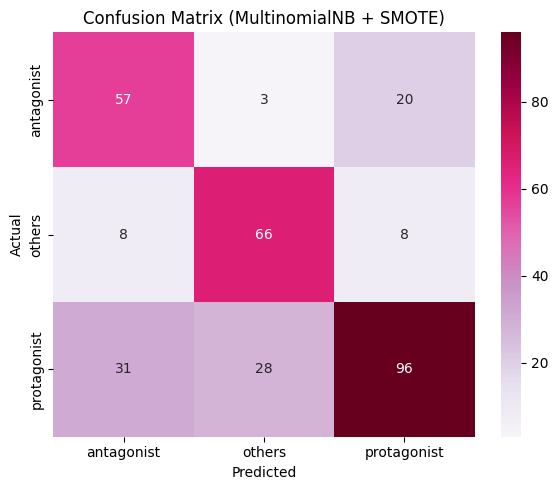


📊 Confusion Matrix:
             antagonist  others  protagonist
antagonist           57       3           20
others                8      66            8
protagonist          31      28           96

🏆 Best MultinomialNB + SMOTE Summary:
              precision    recall  f1-score     support
antagonist     0.593750  0.712500  0.647727   80.000000
others         0.680412  0.804878  0.737430   82.000000
protagonist    0.774194  0.619355  0.688172  155.000000
accuracy       0.690852  0.690852  0.690852    0.690852
macro avg      0.682785  0.712244  0.691110  317.000000
weighted avg   0.704397  0.690852  0.690707  317.000000

🔧 Best Parameters: {'alpha': 1.0}
📈 Precision: 0.6828
📈 Recall:    0.7122
📈 F1-score:  0.6911
🎯 Accuracy:  0.6909

📁 All results saved in: ./naive_bayes_minmax_smote


In [3]:
import pandas as pd
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from imblearn.over_sampling import SMOTE

# Load data
df = pd.read_csv("sentence_level.csv")
df['text'] = df['text'].fillna("")
df['is_primary_in_sentence'] = df['is_primary_in_sentence'].fillna(0)

# Normalize numeric columns
numeric_cols = ['mention_count', 'word_count']
binary_cols = ['is_primary_in_sentence']
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
X_num = df[numeric_cols + binary_cols].astype(float)

# Encode target
le = LabelEncoder()
y = le.fit_transform(df['type'])

# TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=500)
X_text = tfidf.fit_transform(df['text'])
X = hstack([X_num, X_text])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Convert sparse to dense for SMOTE
X_train_dense = X_train.toarray()

# Apply SMOTE to training data
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_dense, y_train)

# Grid search over alpha
param_grid = {'alpha': [0.1, 0.5, 1.0]}
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=3, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)
best_model = grid_search.best_estimator_

# Create output directory
root_dir = "./naive_bayes_minmax_smote"
os.makedirs(root_dir, exist_ok=True)

# Save all params
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results[['param_alpha', 'mean_test_score']].to_csv(f"{root_dir}/all_params_results.csv", index=False)

# Save each variation
for _, row in cv_results.iterrows():
    alpha_val = row['param_alpha']
    tag = f"nb-smote-alpha{str(alpha_val).replace('.', '')}"
    model_dir = os.path.join(root_dir, tag)
    os.makedirs(model_dir, exist_ok=True)

    model = MultinomialNB(alpha=alpha_val)
    model.fit(X_train_resampled, y_train_resampled)

    y_pred_all = model.predict(X.toarray())
    df['predicted_type'] = le.inverse_transform(y_pred_all)
    df.to_csv(os.path.join(model_dir, "prediction.csv"), index=False)
    joblib.dump(model, os.path.join(model_dir, "model.pkl"))

# Evaluate best model
y_pred = best_model.predict(X_test.toarray())
report_dict = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
acc = accuracy_score(y_test, y_pred)

# Save results
report_df.to_csv(f"{root_dir}/classification_report.csv", index=True)
with open(f"{root_dir}/best_params.txt", "w") as f:
    f.write(str(grid_search.best_params_))
joblib.dump(best_model, os.path.join(root_dir, "best_model.pkl"))
joblib.dump(tfidf, os.path.join(root_dir, "tfidf.pkl"))
joblib.dump(le, os.path.join(root_dir, "label_encoder.pkl"))

df['predicted_type'] = le.inverse_transform(best_model.predict(X.toarray()))
df.to_csv(os.path.join(root_dir, "best_prediction.csv"), index=False)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='PuRd')
plt.title('Confusion Matrix (MultinomialNB + SMOTE)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig(f"{root_dir}/confusion_matrix.png")
plt.show()

# Print Summary
print("\n📊 Confusion Matrix:")
print(cm_df)

print("\n🏆 Best MultinomialNB + SMOTE Summary:")
print(report_df)

print(f"\n🔧 Best Parameters: {grid_search.best_params_}")
print(f"📈 Precision: {report_dict['macro avg']['precision']:.4f}")
print(f"📈 Recall:    {report_dict['macro avg']['recall']:.4f}")
print(f"📈 F1-score:  {report_dict['macro avg']['f1-score']:.4f}")
print(f"🎯 Accuracy:  {acc:.4f}")
print(f"\n📁 All results saved in: {root_dir}")


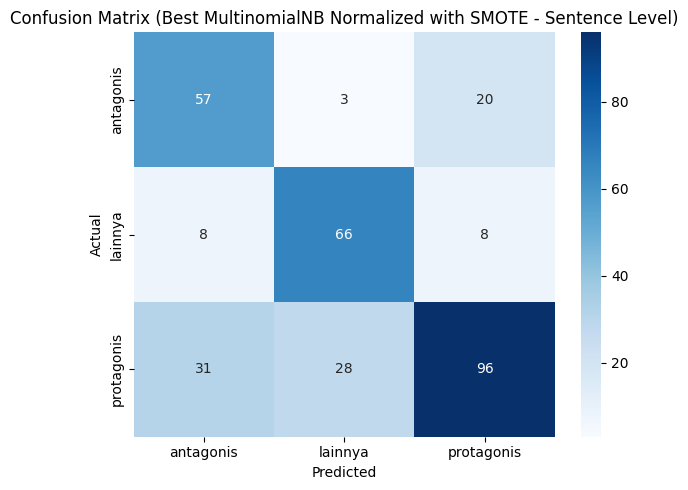

In [1]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns

# Load model, vectorizer, dan label encoder
model = joblib.load("./naive_bayes_minmax_smote/best_model.pkl")
le = joblib.load("./naive_bayes_minmax_smote/label_encoder.pkl")
tfidf = joblib.load("./naive_bayes_minmax_smote/tfidf.pkl")

# Load dan siapkan data
df = pd.read_csv("sentence_level.csv")
df['text'] = df['text'].fillna("")
df['is_primary_in_sentence'] = df['is_primary_in_sentence'].fillna(0)

# Normalisasi ulang numerik
numeric_cols = ['mention_count', 'word_count']
binary_cols = ['is_primary_in_sentence']
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
X_num = df[numeric_cols + binary_cols].astype(float)

# Buat fitur
X_text = tfidf.transform(df['text'])
X = hstack([X_num, X_text])
y = le.transform(df['type'])

# Split ulang data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Prediksi ulang
y_pred = model.predict(X_test.toarray())  # NB model pakai .toarray()

# Mapping label ke Bahasa Indonesia
label_map = {
    'protagonist': 'protagonis',
    'antagonist': 'antagonis',
    'others': 'lainnya'
}
custom_labels = [label_map[label] for label in le.classes_]

# Buat confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=custom_labels, columns=custom_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Best MultinomialNB Normalized with SMOTE - Sentence Level)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


Fitting 3 folds for each of 3 candidates, totalling 9 fits


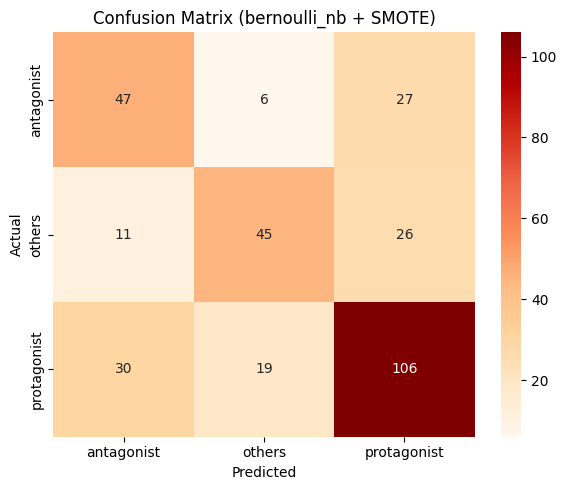


📊 Confusion Matrix (bernoulli_nb + SMOTE):
             antagonist  others  protagonist
antagonist           47       6           27
others               11      45           26
protagonist          30      19          106

🏆 Best bernoulli_nb + SMOTE Summary:
              precision    recall  f1-score     support
antagonist     0.534091  0.587500  0.559524   80.000000
others         0.642857  0.548780  0.592105   82.000000
protagonist    0.666667  0.683871  0.675159  155.000000
accuracy       0.624606  0.624606  0.624606    0.624606
macro avg      0.614538  0.606717  0.608929  317.000000
weighted avg   0.627050  0.624606  0.624493  317.000000

🔧 Best Parameters: {'alpha': 0.1}
📈 Precision: 0.6145
📈 Recall:    0.6067
📈 F1-score:  0.6089
🎯 Accuracy:  0.6246

📁 All results saved in: ./bernoulli_nb_smote
Fitting 3 folds for each of 3 candidates, totalling 9 fits


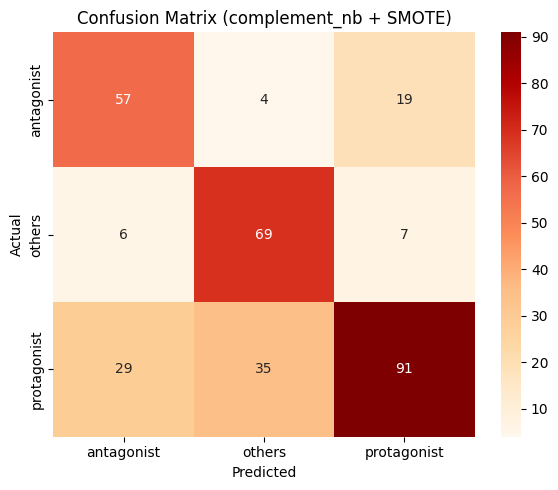


📊 Confusion Matrix (complement_nb + SMOTE):
             antagonist  others  protagonist
antagonist           57       4           19
others                6      69            7
protagonist          29      35           91

🏆 Best complement_nb + SMOTE Summary:
              precision    recall  f1-score     support
antagonist     0.619565  0.712500  0.662791   80.000000
others         0.638889  0.841463  0.726316   82.000000
protagonist    0.777778  0.587097  0.669118  155.000000
accuracy       0.684543  0.684543  0.684543    0.684543
macro avg      0.678744  0.713687  0.686075  317.000000
weighted avg   0.701923  0.684543  0.682317  317.000000

🔧 Best Parameters: {'alpha': 1.0}
📈 Precision: 0.6787
📈 Recall:    0.7137
📈 F1-score:  0.6861
🎯 Accuracy:  0.6845

📁 All results saved in: ./complement_nb_smote


In [4]:
import pandas as pd
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB, ComplementNB
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from imblearn.over_sampling import SMOTE

# Load base data
df = pd.read_csv("sentence_level.csv")
df['text'] = df['text'].fillna("")
df['is_primary_in_sentence'] = df['is_primary_in_sentence'].fillna(0)

# Normalize numeric columns
numeric_cols = ['mention_count', 'word_count']
binary_cols = ['is_primary_in_sentence']
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
X_num = df[numeric_cols + binary_cols].astype(float)
y = LabelEncoder().fit_transform(df['type'])

def run_nb_with_smote(model_class, name, vectorizer_args, param_grid):
    root_dir = f"./{name}_smote"
    os.makedirs(root_dir, exist_ok=True)

    tfidf = TfidfVectorizer(**vectorizer_args)
    X_text = tfidf.fit_transform(df['text'])
    X = hstack([X_num, X_text])

    le = LabelEncoder()
    y = le.fit_transform(df['type'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    # Convert to dense
    X_train_dense = X_train.toarray()

    # Apply SMOTE
    sm = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = sm.fit_resample(X_train_dense, y_train)

    grid_search = GridSearchCV(
        model_class(), param_grid, cv=3,
        scoring='f1_macro', verbose=1, n_jobs=-1
    )
    grid_search.fit(X_train_resampled, y_train_resampled)
    best_model = grid_search.best_estimator_

    # Save all results
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results.to_csv(f"{root_dir}/all_params_results.csv", index=False)

    for _, row in cv_results.iterrows():
        alpha_val = row['param_alpha']
        tag = f"nb-smote-alpha{str(alpha_val).replace('.', '')}"
        model_dir = os.path.join(root_dir, tag)
        os.makedirs(model_dir, exist_ok=True)

        model = model_class(alpha=alpha_val)
        model.fit(X_train_resampled, y_train_resampled)
        y_pred_all = model.predict(X.toarray())
        df['predicted_type'] = le.inverse_transform(y_pred_all)
        df.to_csv(os.path.join(model_dir, "prediction.csv"), index=False)
        joblib.dump(model, os.path.join(model_dir, "model.pkl"))

    # Evaluate best model
    y_pred = best_model.predict(X_test.toarray())
    report_dict = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    acc = accuracy_score(y_test, y_pred)

    # Save everything
    report_df.to_csv(f"{root_dir}/classification_report.csv", index=True)
    with open(f"{root_dir}/best_params.txt", "w") as f:
        f.write(str(grid_search.best_params_))

    joblib.dump(best_model, os.path.join(root_dir, "best_model.pkl"))
    joblib.dump(tfidf, os.path.join(root_dir, "tfidf.pkl"))
    joblib.dump(le, os.path.join(root_dir, "label_encoder.pkl"))

    df['predicted_type'] = le.inverse_transform(best_model.predict(X.toarray()))
    df.to_csv(os.path.join(root_dir, "best_prediction.csv"), index=False)

    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='OrRd')
    plt.title(f"Confusion Matrix ({name} + SMOTE)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(f"{root_dir}/confusion_matrix.png")
    plt.show()

    print(f"\n📊 Confusion Matrix ({name} + SMOTE):")
    print(cm_df)
    print(f"\n🏆 Best {name} + SMOTE Summary:")
    print(report_df)
    print(f"\n🔧 Best Parameters: {grid_search.best_params_}")
    print(f"📈 Precision: {report_dict['macro avg']['precision']:.4f}")
    print(f"📈 Recall:    {report_dict['macro avg']['recall']:.4f}")
    print(f"📈 F1-score:  {report_dict['macro avg']['f1-score']:.4f}")
    print(f"🎯 Accuracy:  {acc:.4f}")
    print(f"\n📁 All results saved in: {root_dir}")

# Run for BernoulliNB (binary TF)
run_nb_with_smote(
    model_class=BernoulliNB,
    name="bernoulli_nb",
    vectorizer_args={'max_features': 500, 'binary': True},
    param_grid={'alpha': [0.1, 0.5, 1.0]}
)

# Run for ComplementNB
run_nb_with_smote(
    model_class=ComplementNB,
    name="complement_nb",
    vectorizer_args={'max_features': 500},
    param_grid={'alpha': [0.1, 0.5, 1.0]}
)


In [4]:
import os
import pandas as pd

# Folder names (relative to current working dir)
folders = [
    "random_forest_normalized",
    "logistic_regression_normalized",
    "linear_svc_normalized",
    "naive_bayes_minmax",
    "naive_bayes_minmax_smote",
    "bernoulli_nb_minmax",
    "bernoulli_nb_smote",
    "complement_nb_minmax",
    "complement_nb_smote",
    "svc_poly_only",
    "svc_rbf_only"
]

results = []

for folder in folders:
    report_path = os.path.join(folder, "classification_report.csv")
    if os.path.exists(report_path):
        df = pd.read_csv(report_path, index_col=0)
        macro = df.loc["macro avg"]
        acc = df.loc["accuracy"]["f1-score"] if "accuracy" in df.index else None  # accuracy stored in 'f1-score' column

        model_name = (
            folder.replace("_minmax", "")
                  .replace("_normalized", "")
                  .replace("_smote", " + SMOTE")
                  .replace("_", " ")
                  .title()
        )

        results.append({
            "Model": model_name,
            "Precision": macro["precision"],
            "Recall": macro["recall"],
            "F1-score": macro["f1-score"],
            "Accuracy": acc,
            "Support": macro["support"]
        })

# Sort leaderboard
leaderboard_df = pd.DataFrame(results)
leaderboard_df = leaderboard_df.sort_values("F1-score", ascending=False).reset_index(drop=True)

# Save + print
leaderboard_df.to_csv("sentence_level_normalized_leaderboard.csv", index=False)
print("\n🏆 SENTENCE-LEVEL (Normalized) LEADERBOARD:")
print(leaderboard_df)



🏆 SENTENCE-LEVEL (Normalized) LEADERBOARD:
                    Model  Precision    Recall  F1-score  Accuracy  Support
0           Random Forest   0.890708  0.899705  0.894825  0.895899    317.0
1            Svc Rbf Only   0.838937  0.835867  0.837369  0.845426    317.0
2           Svc Poly Only   0.824138  0.858068  0.830361  0.829653    317.0
3              Linear Svc   0.766658  0.791572  0.772372  0.776025    317.0
4     Logistic Regression   0.742194  0.749512  0.745591  0.753943    317.0
5     Naive Bayes + Smote   0.682785  0.712244  0.691110  0.690852    317.0
6   Complement Nb + Smote   0.678744  0.713687  0.686075  0.684543    317.0
7           Complement Nb   0.682927  0.696148  0.685022  0.694006    317.0
8             Naive Bayes   0.702903  0.673407  0.682894  0.706625    317.0
9            Bernoulli Nb   0.662677  0.670014  0.665999  0.671924    317.0
10   Bernoulli Nb + Smote   0.614538  0.606717  0.608929  0.624606    317.0
